In [1]:
from snp_query_box.dsnp_transform import callLogTransform
# for dev purpose - get username and password
#import getpass
import os
USERNAME = os.getenv('USERNAME').lower()
#PASSWORD = getpass.getpass()
new_pull = False

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt

%matplotlib inline

import datetime as dt
import time
import warnings
from dateutil.relativedelta import relativedelta


from snp_query_box import DsnpHelperFunction, snpQueries

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [3]:
print(f"User: {USERNAME} Started creating member_cm_engagement_df, call_log_df and monthly_active_member_utr_dtr_df file in shared storage")

User: a845514 Started creating member_cm_engagement_df, call_log_df and monthly_active_member_utr_dtr_df file in shared storage


In [4]:
start_time = time.time()

In [5]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=WUHWzVP9dhl4bBCoXA5O0voYXV2UMy&access_type=offline&code_challenge=GJAK8EmlYMLzwRZWlVN9UDfjcXS5thZrHwbysda_fxQ&code_challenge_method=S256


Credentials saved to file: [C:\Users\A845514\AppData\Roaming\gcloud\application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).
Cannot add the project "edp-prod-mdcrbi-starsbi" to ADC as the quota project because the account in ADC does not have the "serviceusage.services.use" permission on this pr

In [6]:
today = dt.datetime.today()
today_str = today.strftime('%Y-%m-%d')
last_date_of_last_month_str = DsnpHelperFunction.last_date_of_last_month(today_str, output_type="string")
last_date_of_last_month = DsnpHelperFunction.last_date_of_last_month(today_str)

last_month = last_date_of_last_month_str[:7]
one_year_rolling_back_date = pd.Timestamp(last_date_of_last_month + dt.timedelta(days=1) - relativedelta(years = 1))
print("one_year_rolling_back_date")
print(one_year_rolling_back_date)

first_date_of_year = DsnpHelperFunction.first_date_of_year(today_str, output_type="string")
print("first_date_of_year")
print(first_date_of_year)
first_date_of_last_month_str = DsnpHelperFunction.first_date_of_last_month(today_str, output_type="string")
print("first_date_of_last_month_str")
print(first_date_of_last_month_str)

pulled_data_date = last_month
comp_report_data_month = last_month
hra_report_data_month = last_month
reporting_end_date = last_date_of_last_month_str
print("reporting_end_date")
print(reporting_end_date)

one_year_rolling_back_date
2024-06-01 00:00:00
first_date_of_year
2025-01-01
first_date_of_last_month_str
2025-05-01
reporting_end_date
2025-05-31


In [7]:
# if transition time first month...
if today_str.split('-')[1] =='01':
    first_date_of_year = str(int(first_date_of_year.split('-')[0])-1) + \
        '-01-01'
    print('Trainsition time, first date of year is updated by previous year:' + first_date_of_year)
    #first_date_of_year = '2024-01-01'

In [8]:
# 3 years back default
year_back = 3
year_rolling_back_date = last_date_of_last_month + dt.timedelta(days=1) - relativedelta(years = year_back)

call_log_date1 = year_rolling_back_date.strftime('%Y-%m-%d')
call_log_date2 = today_str   #it was reporting_end_date

In [9]:
storage_path = r'//mbip/medicarepBI/Projects/COE/DSNP/dsnp_data_storage/monthly_flat_files'
output_path = f'{storage_path}/{reporting_end_date}'

isExist = os.path.exists(output_path)
print(output_path)
if not isExist:
    # Create a new directory because it does not exist
     os.makedirs(output_path)
     print("The new directory is created!")
else:
      print("The folder already exist")
print("Output files will sit in the folder above.")

//mbip/medicarepBI/Projects/COE/DSNP/dsnp_data_storage/monthly_flat_files/2025-05-31
The folder already exist
Output files will sit in the folder above.


In [10]:
call_log_date1

'2022-06-01'

In [11]:
call_log_date2

'2025-06-04'

In [12]:
if new_pull:
    pull_call_log_all_dsnp = snpQueries.pull_call_log_all_dsnp_bq(call_log_date1,call_log_date2)
    print("data pulled!")
    pull_call_log_all_dsnp.to_parquet(f"{output_path}/pull_call_log_all_dsnp.parquet")
else:
    try:
        pull_call_log_all_dsnp = pd.read_parquet(f"{output_path}/pull_call_log_all_dsnp.parquet")
    except:
        pull_call_log_all_dsnp = snpQueries.pull_call_log_all_dsnp_bq(call_log_date1,call_log_date2)
        print("data pulled!")
        pull_call_log_all_dsnp.to_parquet(f"{output_path}/pull_call_log_all_dsnp.parquet")

data pulled!


In [13]:
pull_call_log_all_dsnp.cl_contact_dts.max()

Timestamp('2025-06-04 06:18:00+0000', tz='UTC')

In [14]:
#Prepare call log data, one year back
call_log_df = callLogTransform.clean_call_log(pull_call_log_all_dsnp, exclude_cec_user=False)
call_log_timestamp_clean = callLogTransform.call_log_timestamp_clean(call_log_df, threshold_min = 60)

most_recent_call_log_df = callLogTransform.get_most_recent_call_with_utr_flag(call_log_timestamp_clean, one_year_rolling_back_date, today_str)
member_cm_engagement_df = callLogTransform.get_cm_engagement_rate(call_log_timestamp_clean, one_year_rolling_back_date, today_str)

most_recent_call_log_df_ytd = callLogTransform.get_most_recent_call_with_utr_flag(call_log_timestamp_clean, first_date_of_year, today_str)
member_cm_engagement_df_ytd = callLogTransform.get_cm_engagement_rate(call_log_timestamp_clean, first_date_of_year, today_str)

In [15]:
member_call_log_final_df = most_recent_call_log_df.merge(member_cm_engagement_df, how="left", on="Member_ID")
member_call_log_final_df[(member_call_log_final_df["final_utr"] == 1) & (member_call_log_final_df["final_dtr"]==1)]
member_call_log_final_df["final_utr"].value_counts()

final_utr
0    839179
1     37062
Name: count, dtype: int64

In [16]:
member_call_log_final_df_ytd = most_recent_call_log_df_ytd.merge(member_cm_engagement_df_ytd, how="left", on="Member_ID")
member_call_log_final_df_ytd[(member_call_log_final_df_ytd["final_utr"] == 1) & (member_call_log_final_df_ytd["final_dtr"]==1)]
member_call_log_final_df_ytd["final_utr"].value_counts()

final_utr
0    839179
1     37062
Name: count, dtype: int64

In [17]:
#Let's make it mutually exclusive, when UTR, it is not DTR 
member_call_log_final_df["final_dtr"] = np.where((member_call_log_final_df["final_utr"] == 1) & (member_call_log_final_df["final_dtr"]==1), 0, member_call_log_final_df["final_dtr"])
member_call_log_final_df_ytd["final_dtr"] = np.where((member_call_log_final_df_ytd["final_utr"] == 1) & (member_call_log_final_df_ytd["final_dtr"]==1), 0, member_call_log_final_df_ytd["final_dtr"])

In [18]:
select_columns = ["final_utr", "total_call_count", "total_non_successful", "non_successful_rate", "final_dtr", "cm_engaged"]
ytd_columns = []
for col in select_columns:
    new_col = col + '_ytd'
    member_call_log_final_df_ytd = member_call_log_final_df_ytd.rename(columns={col: new_col})
    ytd_columns.append(new_col)

one_year_back_columns = []
for col in select_columns:
    new_col = col + '_one_year_back'
    member_call_log_final_df = member_call_log_final_df.rename(columns={col: new_col})
    one_year_back_columns.append(new_col)

In [19]:
member_cm_engagement_df = member_call_log_final_df.merge(member_call_log_final_df_ytd[ytd_columns + ["Member_ID"]], how="left", on="Member_ID")
member_cm_engagement_df.head(2)

,Member_ID,most_recent_cl_call_log_drctn_type_desc,most_recent_cl_call_log_method_type_desc,most_recent_cl_call_log_rel_type_desc,most_recent_cl_object_typ_desc,most_recent_cl_category_typ_desc,most_recent_cl_attempts_typ_key_desc,most_recent_cl_attempt_status_key_desc,most_recent_cl_contact_dts,most_recent_contact_date,most_recent_cur_utr,most_recent_cur_dtr,most_recent_cl_call_log_type_desc,most_recent_cl_comments_txt,final_utr_one_year_back,recent_successful_calls,total_call_count_one_year_back,total_non_successful_one_year_back,non_successful_rate_one_year_back,final_dtr_one_year_back,cm_engaged_one_year_back,final_utr_ytd,total_call_count_ytd,total_non_successful_ytd,non_successful_rate_ytd,final_dtr_ytd,cm_engaged_ytd
0,100230403,,Phone - Outbound,Member/Self,,,Attempt 1,Unsuccessful Left Message,2025-04-30 09:42:00,2025-04-30,0,1,['HRA Outreach'],[],0,NaN,8.0,8.0,1.0,1.0,0.0,0,4.0,4.0,1.0,1.0,0.0
1,100678005,,Phone - Outbound,Member/Self,,,Attempt 1,Successful Refused,2023-10-12 16:45:37,2023-10-12,0,1,['HRA Outreach'],['Adrienne Matlock'],0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [20]:
member_cm_engagement_df.most_recent_cl_contact_dts.max()

Timestamp('2025-06-04 00:54:00')

In [21]:
#save it for monthly aggregation
member_cm_engagement_df.to_parquet(f"{output_path}/member_cm_engagement_df.parquet")
call_log_df.to_parquet(f'{output_path}/call_log_df.parquet')

In [22]:
#TODO update this path
#condensed_member_path = r"\\mbip\medicarepBI\Projects\COE\DSNP\Ting\condensed_dsnp_mbr_2025.pkl"
#condensed_member_path = output_path

condensed_df = pd.read_parquet(f'{output_path}/condensed_dsnp_mbr.parquet')

monthly_active_member_utr_dtr_df = callLogTransform.get_chronic_utr(call_log_df, condensed_df)

2024-06-01
2025-05-31
2024-05-01
2025-04-30
2024-04-01
2025-03-31
2024-02-29
2025-02-28
2024-02-01
2025-01-31
2024-01-01
2024-12-31
2023-12-01
2024-11-30
2023-11-01
2024-10-31
2023-10-01
2024-09-30
2023-09-01
2024-08-31
2023-08-01
2024-07-31
2023-07-01
2024-06-30
2023-06-01
2024-05-31
2023-05-01
2024-04-30
2023-04-01
2024-03-31
2023-03-01
2024-02-29
2023-02-01
2024-01-31
2023-01-01
2023-12-31
2022-12-01
2023-11-30
2022-11-01
2023-10-31
2022-10-01
2023-09-30
2022-09-01
2023-08-31
2022-08-01
2023-07-31
2022-07-01
2023-06-30
moving month UTR to see how long member is on UTR status
If members are on UTR more than 12month, count as Chronic UTR


In [23]:
monthly_active_member_utr_dtr_df

,Member_ID,active_month,total_call_count,total_non_successful,non_successful_rate,dtr,utr,utr_on_going_month,chronic_utr
0,001006261015,2024-01-01,0.0,0.0,NaN,0.0,0.0,0.0,0
1,001006261015,2024-02-01,0.0,0.0,NaN,0.0,0.0,0.0,0
2,001006261015,2024-03-01,0.0,0.0,NaN,0.0,0.0,0.0,0
3,001006261015,2024-04-01,0.0,0.0,NaN,0.0,0.0,0.0,0
4,001006261015,2024-05-01,0.0,0.0,NaN,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
10236671,990013755019,2025-01-01,0.0,0.0,NaN,0.0,0.0,0.0,0
10236672,990013755019,2025-02-01,0.0,0.0,NaN,0.0,0.0,0.0,0
10236673,990013755019,2025-03-01,0.0,0.0,NaN,0.0,0.0,0.0,0
10236674,990013755019,2025-04-01,0.0,0.0,NaN,0.0,0.0,0.0,0


<Axes: >

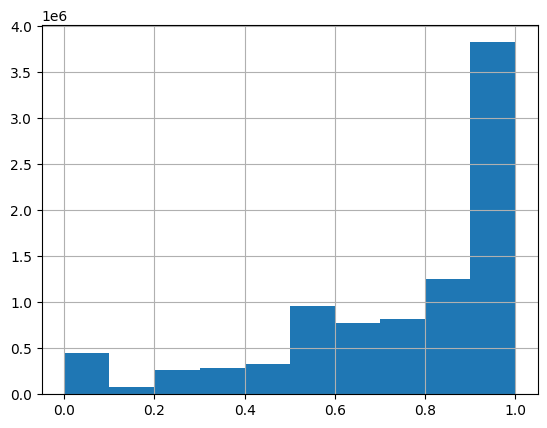

In [24]:
monthly_active_member_utr_dtr_df.non_successful_rate.hist()

In [25]:
monthly_active_member_utr_dtr_df.chronic_utr.value_counts()

chronic_utr
0    10229736
1        6940
Name: count, dtype: int64

In [26]:
monthly_active_member_utr_dtr_df[monthly_active_member_utr_dtr_df.chronic_utr==1].tail(3)

,Member_ID,active_month,total_call_count,total_non_successful,non_successful_rate,dtr,utr,utr_on_going_month,chronic_utr
8826595,102008720800,2025-05-01,11.0,11.0,1.000000,0.0,1.0,12.0,1
8861166,102011038900,2025-05-01,14.0,13.0,0.928571,0.0,1.0,12.0,1
8880658,102012164300,2025-05-01,3.0,3.0,1.000000,0.0,1.0,12.0,1


In [27]:
member_cm_engagement_df.head()

,Member_ID,most_recent_cl_call_log_drctn_type_desc,most_recent_cl_call_log_method_type_desc,most_recent_cl_call_log_rel_type_desc,most_recent_cl_object_typ_desc,most_recent_cl_category_typ_desc,most_recent_cl_attempts_typ_key_desc,most_recent_cl_attempt_status_key_desc,most_recent_cl_contact_dts,most_recent_contact_date,most_recent_cur_utr,most_recent_cur_dtr,most_recent_cl_call_log_type_desc,most_recent_cl_comments_txt,final_utr_one_year_back,recent_successful_calls,total_call_count_one_year_back,total_non_successful_one_year_back,non_successful_rate_one_year_back,final_dtr_one_year_back,cm_engaged_one_year_back,final_utr_ytd,total_call_count_ytd,total_non_successful_ytd,non_successful_rate_ytd,final_dtr_ytd,cm_engaged_ytd
0,100230403,,Phone - Outbound,Member/Self,,,Attempt 1,Unsuccessful Left Message,2025-04-30 09:42:00,2025-04-30,0,1,['HRA Outreach'],[],0,NaN,8.0,8.0,1.000000,1.0,0.0,0,4.0,4.0,1.00,1.0,0.0
1,100678005,,Phone - Outbound,Member/Self,,,Attempt 1,Successful Refused,2023-10-12 16:45:37,2023-10-12,0,1,['HRA Outreach'],['Adrienne Matlock'],0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,101039941100,,Phone - Outbound,Member/Self,,,Attempt 3,Unsuccessful Left Message,2024-01-26 16:40:33,2024-01-26,0,1,['HRA Outreach'],['Diana Gonzalez'],0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
3,101039985900,,Phone - Outbound,Member/Self,,,Attempt 1,Unsuccessful No Answer,2025-05-19 09:25:00,2025-05-19,0,1,['Inpatient Outreach'],['THE HOSPITAL OF CENTRAL CONNECTICUT-NEW BRIT...,0,"[{'cl_call_log_rel_type_desc': 'Member/Self', ...",10.0,6.0,0.600000,0.0,1.0,0,5.0,4.0,0.80,1.0,1.0
4,101039986100,,Phone - Outbound,Member/Self,,,Attempt 1,Unsuccessful No Answer,2025-02-26 13:32:00,2025-02-26,0,1,"['Annual Face to Face Visit', 'Care Planning']","['someone picked up and disconnected', 'someon...",0,"[{'cl_call_log_rel_type_desc': 'Member/Self', ...",6.0,5.0,0.833333,1.0,1.0,0,4.0,3.0,0.75,1.0,1.0


In [28]:
monthly_active_member_utr_dtr_df.to_parquet(f'{output_path}/monthly_active_member_utr_dtr_df.parquet')

In [29]:
print("Process time -- %s seconds" % (time.time() - start_time))

Process time -- 5637.500629901886 seconds
